In [1]:
## Binær klassifisering US / Ikke US
## Mann / Kvinne

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.svm import SVC, SVR, LinearSVR, LinearSVC
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis



# Hente inn datatsettet, filtrere feil og utliggere alder
df_data = pd.read_csv("b5_svar.csv")
df_data = df_data[df_data["gender"].isin([1, 2]) &  df_data.age.isin(range(16,51))]
spm_grupper = {"E": "Extraversion", "A": "Agreeableness", "C": "Conscientiousness", "N": "Emotional Stability", "O": "Intellect/Imagination"}
five = ['N', 'C', 'E', 'A', 'O']
spm_c = [c for c in df_data.columns if c[-1].isdigit() and not c.startswith("Unnamed")] # De 50 spørsmålene
print(list(df_data.columns))
print("data values:",df_data[spm_c].min().min(), df_data[spm_c].max().max())

['Unnamed: 0', 'race', 'age', 'engnat', 'gender', 'hand', 'source', 'country', 'E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9', 'O10', 'E', 'N', 'A', 'C', 'O']
data values: 1.0 5.0


In [3]:
# Forberede data for å estimere på opprinnelsesland

cc5 = ['US', 'GB', 'IN', 'AU', 'CA']
c_conv = {'US':1, 'GB':2, 'IN':3, 'AU':4, 'CA':5, 'other':0}
"""
Det fungerte dårlig med disse seks klassene.
0    5500
1    7322
2    1233
3    1396
4     782
5     746
 Prøver på bare US / Ikke US Binært.
"""
df_cc2 = df_data.copy()
df_cc2["cc_2"] = df_cc2["country"].where(df_data["country"]== "US", "other")

x = df_cc2[spm_c]
y = df_cc2["cc_2"].map(c_conv)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)

print("Y values:\n",y.value_counts().sort_index())
print("\nX shapes:\n", [x.shape for x in [x_train, x_test]])

Y values:
 0    9657
1    7322
Name: cc_2, dtype: int64

X shapes:
 [(13583, 50), (3396, 50)]


In [9]:
#SVC, beste modell fra eksperimentene under
steps = [('scaler', StandardScaler()), ('model', LinearSVC(C = 1)) ]
pipeline = Pipeline(steps)
pipeline.fit(x_train, y_train)
pipeline.score(x_test, y_test)
pred = pipeline.predict(x_test)


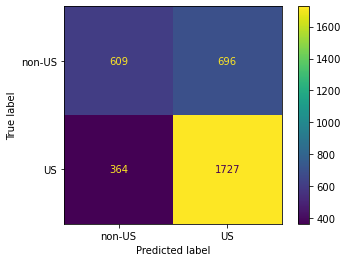

In [37]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
plot_confusion_matrix(pipeline, x_test, y_test, display_labels = ["non-US", "US"])

1     6689
2    10290
Name: gender, dtype: int64
1    1305
2    2091
Name: gender, dtype: int64
[[ 608  697]
 [ 365 1726]]
0.533801580333626
F1-score for Male:	 0.534
F1-score for Female:	 0.765


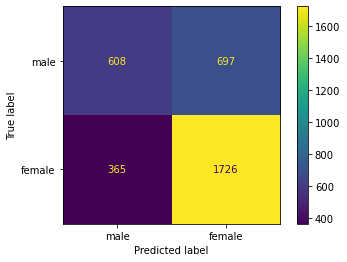

In [47]:
#Skille male fra female
#1=Male, 2=Female,
mf_dict = {1: "Male", 2: "Female"}
df_mf = df_data.copy()[df_data["gender"].isin([1,2])]
print(df_mf["gender"].value_counts().sort_index())
x = df_mf[spm_c]
y = df_mf["gender"]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 99)
print(y_test.value_counts().sort_index())
steps = [('scaler', StandardScaler()), ('model', LinearSVC(C = 1)) ]
pipeline = Pipeline(steps)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(pipeline, x_test, y_test, display_labels = ["male", "female"])
print(f1_score(y_test, y_pred))
for s in [1,2]:
    print("F1-score for", mf_dict[s]+":\t", 
            round(f1_score(y_test, y_pred, pos_label=s, average = 'binary' ),3))


1     6688
2    10283
Name: gender, dtype: int64
1    1338
2    2057
Name: gender, dtype: int64
[[ 588  750]
 [ 329 1728]]
0.5215077605321508
F1-score for Male:	 0.522
F1-score for Female:	 0.762


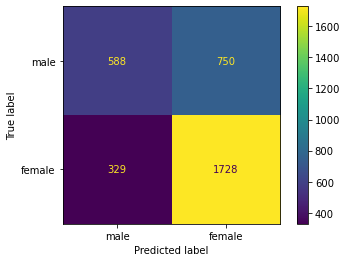

In [80]:
#Skille male fra female, med ekstra info
#1=Male, 2=Female,
# Å ta med landsinformasjon gjorde det littegranne dårligere
n = 0
cc_int = {}
for x,y in  df_data["country"].value_counts().iteritems(): # Most frequent first
    cc_int[x] = n
    n += 1

mf_dict = {1: "Male", 2: "Female"}
df_mf = df_data.copy()[df_data["gender"].isin([1,2])]
df_mf = df_mf[df_mf.country.notnull()]
df_mf["c_int"]= df_mf["country"].map(cc_int)
print(df_mf["gender"].value_counts().sort_index())
x = df_mf[spm_c+["c_int"]]
y = df_mf["gender"]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 99)
print(y_test.value_counts().sort_index())
steps = [('scaler', StandardScaler()), ('model', LinearSVC(C = 1)) ]
pipeline = Pipeline(steps)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(pipeline, x_test, y_test, display_labels = ["male", "female"])
print(f1_score(y_test, y_pred))
for s in [1,2]:
    print("F1-score for", mf_dict[s]+":\t", 
            round(f1_score(y_test, y_pred, pos_label=s, average = 'binary' ),3))

1     6689
2    10290
Name: gender, dtype: int64
1    1305
2    2091
Name: gender, dtype: int64
[[ 478  827]
 [ 291 1800]]
F1 for settet: 0
F1-score for Male:	 0.461
F1-score for Female:	 0.763


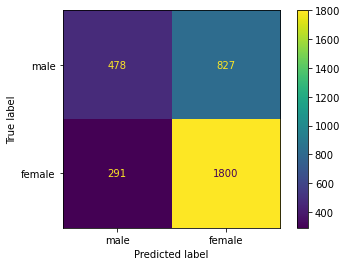

In [83]:
#Skille male fra female utfra de 5 average verdiene
#1=Male, 2=Female,
mf_dict = {1: "Male", 2: "Female"}
five = ['N', 'C', 'E', 'A', 'O']
df_mf = df_data.copy()[df_data["gender"].isin([1,2])]
print(df_mf["gender"].value_counts().sort_index())
x = df_mf[five]
y = df_mf["gender"]
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 99)
print(y_test.value_counts().sort_index())
steps = [('scaler', StandardScaler()), ('model', LinearSVC(C = 0.05)) ]
pipeline = Pipeline(steps)
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)
print(confusion_matrix(y_test, y_pred))
plot_confusion_matrix(pipeline, x_test, y_test, display_labels = ["male", "female"])
print("F1 for settet:", round(f1_score(y_test, y_pred)))
for s in [1,2]:
    print("F1-score for", mf_dict[s]+":\t", 
            round(f1_score(y_test, y_pred, pos_label=s, average = 'binary' ),3))


In [82]:
# Grid search, flere modeller

modeller = [
    {"name": "KNeighborsClassifier", "model": KNeighborsClassifier(), 
                    "params": {'model__n_neighbors': [7,9,11,13]}},



      {"name": "GaussianNB", "model": GaussianNB(), 
                     "params": {}},
  
    {"name": "RandomForestClassifier", "model": RandomForestClassifier(max_depth=5, max_features=1),
                    "params": {"model__n_estimators": [10,30,50]}},



    {"name": "LinearSVC", "model": LinearSVC(),
                        "params": {"model__C":[0.005, 0.1,0.5, 1.0, 2.0, 5.0]}}
     ]

   

grids = {} # Collect individual pipelines

for m in modeller: #Sjekke pat arameternavnene er riktige
    given = set([p[7:] for p in m["params"]])
    pool = set(m["model"].get_params())
    assert given.issubset(pool), print(m["name"],given, pool)

for m in modeller:
    steps = [('scaler', StandardScaler()), ('model', m["model"]) ]
    pipeline = Pipeline(steps)
    parameters = m["params"]

    grid = GridSearchCV(pipeline, param_grid = parameters, cv=3, verbose = 2)
    grid.fit(x_train, y_train)
    print(m["name"],": Modellen scorer %3.2f " % -grid.score(x_test, y_test), "Parametre:", grid.best_params_)
    with open ("country_bin.txt", "a") as wf:
        wf.write(m["name"]+": Modellen scorer %3.2f  " % -grid.score(x_test, y_test)+ "Parametre:"+ str(grid.best_params_)+"\n")
    grids[m["name"]] = grid

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ...............................model__n_neighbors=7; total time=   0.1s
[CV] END ...............................model__n_neighbors=7; total time=   0.1s
[CV] END ...............................model__n_neighbors=7; total time=   0.1s
[CV] END ...............................model__n_neighbors=9; total time=   0.1s
[CV] END ...............................model__n_neighbors=9; total time=   0.1s
[CV] END ...............................model__n_neighbors=9; total time=   0.1s
[CV] END ..............................model__n_neighbors=11; total time=   0.1s
[CV] END ..............................model__n_neighbors=11; total time=   0.1s
[CV] END ..............................model__n_neighbors=11; total time=   0.1s
[CV] END ..............................model__n_neighbors=13; total time=   0.1s
[CV] END ..............................model__n_neighbors=13; total time=   0.1s
[CV] END ..............................model__n_n